# Direct TSQR
**Input**: Matrix $A$ of size $m\times n$ (with $m\gg n$)
1) **First step**: The matrix $A$ is subdivided into $p$ sub-matricies of size $m_j\times n$ and *map* procedure, perform a local QR decomposition on each sub-matrix, resulting on $\{(Q^{(1)}_1, R_1),(Q^{(1)}_2, R_2),...,(Q^{(1)}_p, R_p)\}$, where $Q_j^{(1)}\in\mathbb{R}^{m_j\times n}$ and $R_j\in\mathbb{R}^{n\times n}$.
2) **Second step**: a *reduce* task collect each $R_j$ into a $np\times n$ matrix. A second QR decomposition returns a $\tilde{Q}=[Q^{(2)}_1,...,Q^{(2)}_p]^T \in \mathbb{R}^{np\times n}$ (each $Q_j^{(2)}$ is $n\times n$) and $\tilde{R}\in\mathbb{R}^{n\times n}$
3) **Third step**: a *map* task build the final $Q$ matrix using $Q_j=Q_j^{(1)}Q_j^{(2)}$


In [1]:
from dask.distributed import Client, wait
from dask import delayed, compute
import dask.array as da

from numpy.linalg import qr
import numpy as np

from operator import getitem

N_WORKERS = 16
THREADS_PER_WORKER = 1
MEMORY_PER_WORKER = "1GB"
client = Client(
    n_workers=N_WORKERS,
    threads_per_worker=THREADS_PER_WORKER,
    memory_limit=MEMORY_PER_WORKER,
)

print(f"DASK Client with {N_WORKERS} workers ({THREADS_PER_WORKER} threads, {MEMORY_PER_WORKER} memory)")
print("DASK Dashboard link:", client.dashboard_link)

DASK Client with 16 workers (1 threads, 1GB memory)
DASK Dashboard link: http://127.0.0.1:8787/status


In [2]:
def direct_tsqr(A : da.Array, mode : str = None) -> tuple[delayed, delayed]:
    '''
    Compute the GR decomposition for tall-and-skinny matrices using the Direct TSQR algorithm.

    Parameters
    ----------
        A : da.Array
            Input matrix (m x n) with m >> n, stored as a distributed Dask array.
        mode : {'r'}, optional, default: None
            - 'r': returns R only with dimensions (n x n)
            - None: returns both Q (m x n) and R (n x n)

    Returns
    -------
        Q : delayed or None
            Orthogonal matrix with dimensions (m x n) if mode is None, else None.
        R : delayed
            Upper triangular matrix with dimensions (n x n).
    '''
    A_blocks = A.to_delayed().ravel().tolist()

    # Step 1: (map) perform QR decomposition in parallel on each block
    QR1 = [delayed(qr)(block) for block in A_blocks]
    Q1s = [delayed(getitem)(qr, 0) for qr in QR1]
    R1s = [delayed(getitem)(qr, 1) for qr in QR1]

    # Stack R1s vertically
    R1 = delayed(np.vstack)(R1s)

    # Step 2: (reduce) perform global QR decomposition
    QR2 = delayed(qr)(R1)
    Q2 = delayed(getitem)(QR2, 0)
    R2 = delayed(getitem)(QR2, 1)

    if mode == "r":
        return None, R2

    # Step 3: (map) building the final Q by multiplying Qs blocks
    p, n = len(A_blocks), A.shape[1]
    row_chunks = A.chunks[0]

    Q2_blocks = [delayed(np.array)(Q2[i * n:(i + 1) * n, :]) for i in range(p)]
    Qs = [da.from_delayed(delayed(np.matmul)(Q1, Q2b), shape=(rows, n), dtype=A.dtype) 
          for Q1, Q2b, rows in zip(Q1s, Q2_blocks, row_chunks)]
    Q = da.concatenate(Qs, axis=0)

    return Q, R2

In [17]:
m, n = int(1e7), 4
A = da.random.random((m, n), chunks=(m // N_WORKERS, n))
A

dask.array<random_sample, shape=(10000000, 4), dtype=float64, chunksize=(625000, 4), chunktype=numpy.ndarray>

In [18]:
%%time

# Parallel computation with delayed
Q_delayed, R_delayed = direct_tsqr(A)
Q, R = compute(Q_delayed, R_delayed)

CPU times: user 144 ms, sys: 191 ms, total: 335 ms
Wall time: 703 ms


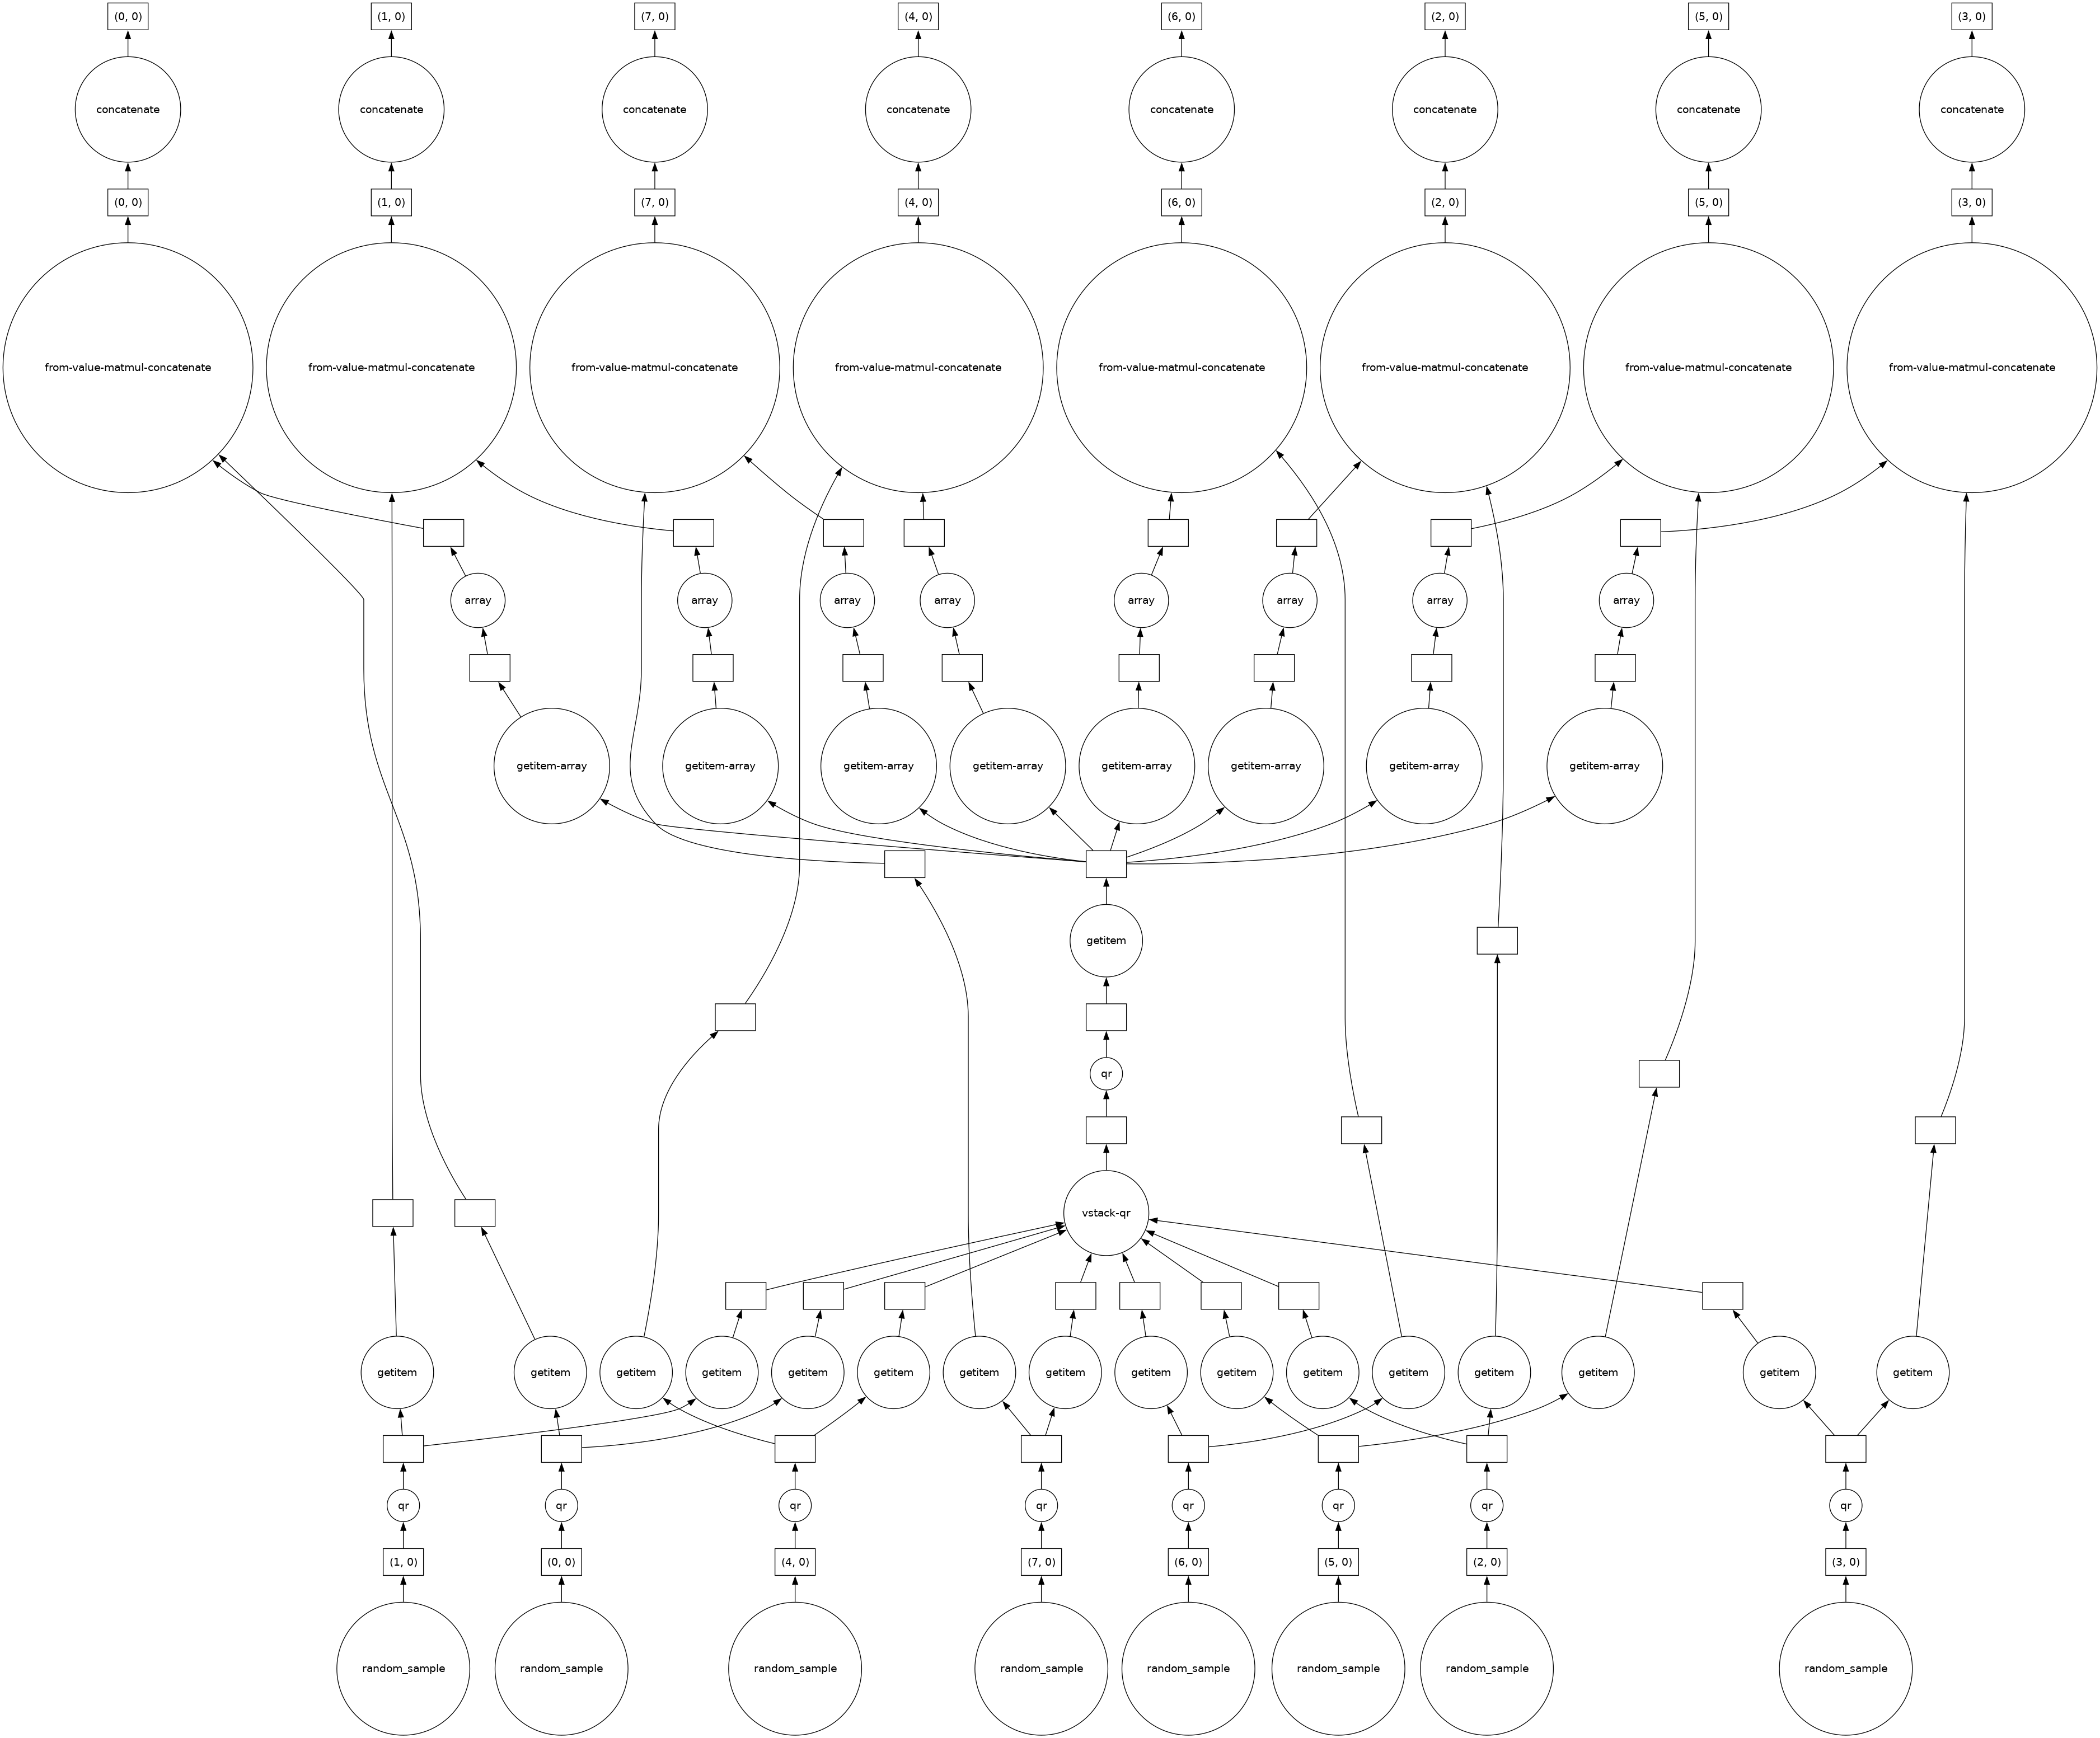

In [5]:
R_delayed.visualize("./fig/Direct_R.png", optimize_graph=True)
Q_delayed.visualize("./fig/Direct_Q.png", optimize_graph=True)

In [19]:
%%time

# Parallel computation with dask implementation
Q_future, R_future = da.linalg.tsqr(A)
Q, R = da.compute(Q_future, R_future)

CPU times: user 110 ms, sys: 192 ms, total: 302 ms
Wall time: 643 ms


In [20]:
# Gathering A for subsequent calculations
A_local = A.compute()

In [21]:
%%time

# Sequential computation 
Q_seq, R_seq = qr(A_local)

CPU times: user 546 ms, sys: 337 ms, total: 884 ms
Wall time: 844 ms


In [22]:
# Check the results
print("Reconstruction error check:", np.isclose(Q @ R, A_local, atol=1e-6).all())
print("Orthogonality check:", np.linalg.norm(Q.T @ Q - np.eye(n), ord='fro') < 1e-6)

Reconstruction error check: True
Orthogonality check: True


In [23]:
client.close()

### Memory considerations
- **Step 1**: each worker has a block of matrix $A$ of $m_j\times n$ elements. Each QR decomposition produce a matrix $Q$ of $m_j\times n$ and $R$ of $n\times n$. The LAPACK routine may allocate up to 3 times of memory (to check).
- **Step 2**: matrix $R$ is stacked in $pn\times n$ and a global QR decomposition is performed (resulting on $pn\times n$ for $Q$ and $n\times n$ for $R$). LAPACK routine can increase the peak memory utilization
- **Step 3**: the matmul produce a $m_j\times n$ and the LAPACK routine can take double the amount (to check)
$$(2m_j n+n^2)+(2p+1)n^2+m_jn\approx 3m_j n$$